## Pipeline to compare reconstruction to target IMC images

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
import cv2 as cv
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
from torch.multiprocessing import Pool, set_start_method
# For utilities
import os, shutil, time

## UNet

In [2]:
# code from https://amaarora.github.io/2020/09/13/unet.html#u-net
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
        self.batchnorm2d = nn.BatchNorm2d(in_ch)
    
    def forward(self, x):
        x = self.batchnorm2d(x)
        x = self.conv1(x)
        x = self.relu(x)
        return self.conv2(x)
#         return self.conv2(self.relu(self.conv1(self.batchnorm2d(x))))


class Encoder(nn.Module):
    def __init__(self, chs=(8,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 40)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)            
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(8,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs)
        self.head = nn.Conv2d(dec_chs[-1], 40, 1)

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out = self.head(out)
        out = F.interpolate(out, (256, 256))
        return out

In [3]:
model = UNet().double()

checkpoint = torch.load('../checkpoints/model-epoch-5-losses-285.453.pth')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [32]:
phys_sec = '10'   # choose which physical section to reconstruct
chunk = '40_35'  # choose which chunk to extract

# load images
stpt_piece = torch.load('../data/val/STPT/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))
imc_reconst = model(stpt_piece.unsqueeze(0)).squeeze()

imc_true = torch.load('../data/val/IMC/{0}/{1}.pt'.format(phys_sec.zfill(2), chunk))

FileNotFoundError: [Errno 2] No such file or directory: '../data/val/STPT/10/40_35.pt'

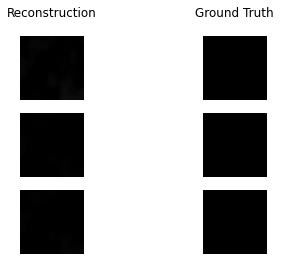

In [33]:
# plot sample and target pairs

nrows = 3
ncols = 2
f, axarr = plt.subplots(nrows, ncols)
for i in range(nrows):
    for j in range(ncols):
        axarr[i, j].axis("off")
        
chs = [5, 15, 35]
axarr[0, 0].set_title('Reconstruction', pad=20)
axarr[0, 1].set_title('Ground Truth', pad=20)
axarr[0, 0].imshow(imc_reconst[chs[0]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[0, 1].imshow(imc_true[chs[0]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[1, 0].imshow(imc_reconst[chs[1]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[1, 1].imshow(imc_true[chs[1]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[2, 0].imshow(imc_reconst[chs[2]].detach().numpy(), cmap='gray', vmin=0, vmax=255)
axarr[2, 1].imshow(imc_true[chs[2]].detach().numpy(), cmap='gray', vmin=0, vmax=255)

In [34]:
# save figure with file name corresponding to physical section and chunk

f.savefig('../figures/{0}_{1}.png'.format(phys_sec, chunk))